# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


In [2]:
df_raw = pd.read_csv("admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [3]:
# frequency table for prestige and whether or not someone was admitted
prestList = ['prestige_1','prestige_2','prestige_3','prestige_4']

#count the number of admitted students in each prestige category
frqTbl = pd.DataFrame({'admitted': [df.admit[df.prestige==1].sum(),
               df.admit[df.prestige==2].sum(),
               df.admit[df.prestige==3].sum(),
               df.admit[df.prestige==4].sum()]},index=prestList)

#count the number of non-admitted students in each category
notAdmitted = pd.DataFrame(columns=['not_admitted'])

m = 1
for n in frqTbl.index:
    notAdmitted.not_admitted[n] = df.admit[df.prestige==m].count() - frqTbl['admitted'][n]
    m += 1

#combine the results into one dataframe
frqTbl = frqTbl.join(notAdmitted.not_admitted)

#check the quantities to make sure we have the same number of students as we started with
print 'sum admitted entries plus not admitted --', frqTbl.admitted.sum()+frqTbl.not_admitted.sum()
print '----------------------------------------------------------'
print 'number of entries in our original data --', df.admit.count()

#print our frequency table
frqTbl.head()

sum admitted entries plus not admitted -- 397
----------------------------------------------------------
number of entries in our original data -- 397


,admitted,not_admitted
prestige_1,33,28
prestige_2,53,95
prestige_3,28,93
prestige_4,12,55


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [4]:
prestigeDummies=pd.get_dummies(df.prestige.astype('int8'),prefix = 'prestige').astype('int8')
prestigeDummies.head()


,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Answer: We need only three class variables: 2, 3, and 4. If all 3 class variables are 0, we know that the prestige should be 1.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [5]:
cols_to_keep = ['admit']

handCalc = df[cols_to_keep].join(prestigeDummies.ix[:, 'prestige_1':])

#number of total observations...
numObs = df.admit.count()
numObs

#calculate odds ratios to be admitted, given your prestige rating for each prestige rating
prestOR = dict()


for n in prestList:    
    
    totPrest = frqTbl.admitted[n] + frqTbl.not_admitted[n] # number of observations with this prestige rating, n11+n01
    totNotPrest = numObs - totPrest # number observations without this prestige rating, n10+n00
    
    totAdmit = frqTbl.admitted.sum() #number of admissions with any prestige rating, n11+n10
    totNotAdmit = frqTbl.not_admitted.sum() #number of non-admissions with any prestige rating, 
    
    numAdmitP = np.float(frqTbl.admitted[n])  # number of admissions with this prestige rating, n11
    numNotAdmitP = np.float(frqTbl.not_admitted[n]) # number of non-admissions with this prestige rating, n01
    
    probAdmit = numAdmitP/(numAdmitP+numNotAdmitP) #probability of being admitted to this school given prestige rating
    probNotAdmit = numNotAdmitP/(numAdmitP+numNotAdmitP) #probability of not being admitted given prestige rating
    
    oddsAdmit = probAdmit/probNotAdmit #odds of being admitted with this prestige rating
    
    numAdmitNP = np.float(totAdmit - numAdmitP)  #number of admissions without this prestige rating, n10
    numNotAdmitNP = np.float(totNotAdmit - numNotAdmitP) #number non-admissions without this prestige rating, n00
    
    probAdmitNP = numAdmitNP/(numAdmitNP + numNotAdmitNP) #Probability of admission without this prestige rating
    probNotAdmitNP = numNotAdmitNP/(numAdmitNP + numNotAdmitNP) #probability of non-admission without this prestige rating

    oddsAdmitNP = probAdmitNP/probNotAdmitNP
    prestOR[n] = oddsAdmit/oddsAdmitNP


frqTbl.keys()    
oddsTbl = pd.DataFrame(data=prestOR,index=['OR_admit'])

frqTbl = frqTbl.join(oddsTbl.transpose())
frqTbl

,admitted,not_admitted,OR_admit
prestige_1,33,28,3.079493
prestige_2,53,95,1.345061
prestige_3,28,93,0.546851
prestige_4,12,55,0.413397


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [6]:
nPrest1 = np.float(frqTbl.admitted['prestige_1'] + frqTbl.not_admitted['prestige_1']) #number prestige 1 obs
admPrest1 = np.float(frqTbl.admitted['prestige_1']) #number prest1 admissions

pAdmit = admPrest1/nPrest1 #probability of admission with prest1
pNoAdmit = 1-pAdmit #probability of no admission with prest1

oddsP1 = (pAdmit)/(pNoAdmit) #odds of admission with prest1

print 'prob admit - ', pAdmit, '| prob no admit - ', pNoAdmit
print 'odds admit - ', oddsP1

prob admit -  0.540983606557 | prob no admit -  0.459016393443
odds admit -  1.17857142857


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [7]:
nPrestOther = frqTbl[['admitted','not_admitted']].loc['prestige_2':].sum().sum() #num obs w/o prest1
nAdmitOther = frqTbl['admitted'].loc['prestige_2':].sum() #num admit w/o prest1

pAdmitOther = np.float(nAdmitOther)/np.float(nPrestOther) #prob admit w/o prest1
pNoAdmitOther = 1-pAdmitOther #prob no admit w/o prest1

oddsAdmitOther = pAdmitOther/pNoAdmitOther #odds admit w/o prest1

print 'prob admit - ', pAdmitOther, 'prob no admit', pNoAdmitOther
print 'odds admit - ', oddsAdmitOther

prob admit -  0.276785714286 prob no admit 0.723214285714
odds admit -  0.382716049383


#### 3.3 Calculate the odds ratio

In [8]:
oddsRatio = oddsP1/oddsAdmitOther
oddsRatio

3.079493087557604

#### 3.4 Write this finding in a sentenance: 

Answer: Not considering gre and gpa, if you attended a # 1 ranked college, the odds of being admitted to grad school are 3.0794 times higher than the odds of not being admitted

#### 3.5 Print the cross tab for prestige_4

In [9]:
ctp4 = pd.crosstab(handCalc.admit,handCalc.prestige_4)
ctp4

prestige_4,0,1
admit,,
0,216,55
1,114,12


#### 3.6 Calculate the OR 

In [10]:
oddsRatio4 = np.float(ctp4[0][0]*ctp4[1][1])/np.float(ctp4[1][0]*ctp4[0][1])
oddsRatio4


0.4133971291866029

#### 3.7 Write this finding in a sentence

Answer: For students attending a # 4 ranked college, the odds of being admitted to grad school are 0.413 times the odds of not being admitted. Hence, these students are far less likely to be admitted than students who attended schools with higher prestige

## Part 4. Analysis

In [11]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(prestigeDummies.ix[:, 'prestige_2':])
print data.head()


   admit    gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61           0           1           0
1      1  660.0  3.67           0           1           0
2      1  800.0  4.00           0           0           0
3      1  640.0  3.19           0           0           1
4      0  520.0  2.93           0           0           1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [12]:
# manually add the intercept
data['intercept'] = 1.0
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380.0,3.61,0,1,0,1.0
1,1,660.0,3.67,0,1,0,1.0
2,1,800.0,4.00,0,0,0,1.0
3,1,640.0,3.19,0,0,1,1.0
4,0,520.0,2.93,0,0,1,1.0


#### 4.1 Set the covariates to a variable called train_cols

In [13]:
train_cols = data[['gre','gpa','prestige_2','prestige_3','prestige_4','intercept']]
train_cols.head()

,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,380.0,3.61,0,1,0,1.0
1,660.0,3.67,0,1,0,1.0
2,800.0,4.00,0,0,0,1.0
3,640.0,3.19,0,0,1,1.0
4,520.0,2.93,0,0,1,1.0


#### 4.2 Fit the model

In [14]:
logit = sm.Logit(data.admit,train_cols)
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Jul 2016   Pseudo R-squ.:                 0.08166
Time:                        14:14:35   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa            0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2    -0.6801      0.317     -2.146      0.032        -1.301    -0.059
prestige_3    -1.3387      0.345     -3.882      0.000        -2.015    -0.663
prestige_4    -1.5534      0.417     -3.721      0.000        -2.372    -0.735
intercept     -3.8769      1.142     -3.393      0.001        -6.116    -1.638
==============================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [16]:
orCoeffs = np.exp(results.params) #odds ratios of coefficients
orCoeffs


gre           1.002221
gpa           2.180027
prestige_2    0.506548
prestige_3    0.262192
prestige_4    0.211525
intercept     0.020716
dtype: float64

In [19]:
cInts = np.exp(results.conf_int(alpha=0.05))
cInts.columns = ['2.5%','97.5%']
cInts['OR']=orCoeffs
cInts


,2.5%,97.5%,OR
gre,1.000074,1.004372,1.002221
gpa,1.136120,4.183113,2.180027
prestige_2,0.272168,0.942767,0.506548
prestige_3,0.133377,0.515419,0.262192
prestige_4,0.093329,0.479411,0.211525
intercept,0.002207,0.194440,0.020716


#### Sanity check:
To verify our results and comprehension, we can calculate the confidence intervals by hand.

For example, if we calculate the CI for gre by hand using z = 1.96 for a 95% confidence interval...

In [25]:
greC = results.params['gre']
zscore = 1.96
greSE = 0.001
lowerBound = greC - zscore*greSE
upperBound = greC + zscore*greSE

print '(', np.exp(lowerBound), ',', np.exp(upperBound), ')'

( 1.0002584367 , 1.004187145 )


We get slightly different results, but I am willing to accept that as being rounding error from not including enough significant digits in the z-score and standard error terms.

#### 4.5 Interpret the OR of Prestige_2

Answer: For students who went to a prestige level 2 school, the odds of admittance are 50.65% lower than students who attended a prestige level 1 school, keeping all other variables constant. This interpretation is due to the fact that we made prestige = 1 our baseline (prestige2 = prestige3 = prestige4 = 0). 

In a general sense, the odds ratios correspond to the change in odds for a one-unit increase in the corresponding predictor variable. So, for a one-unit increase in prestige_2 (prestige_2 changes from 0 to 1), we see a change in the odds by 50.65%.

#### 4.6 Interpret the OR of GPA

Answer: A unit increase in gpa increases the odds of admission by a factor of 2.18 when keeping all other variables constant.
This higher increase makes sense, because gpa ranges only from 0 to 4. A one-unit increase in gpa corresponds to an entire letter grade, so we can expect this to have a fairly large impact.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [26]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [27]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
#print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
#print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
combos.columns = ['gre','gpa','prestige','intercept']
combos.head()

,gre,gpa,prestige,intercept
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


#### 5.1 Recreate the dummy variables

In [28]:
# recreate the dummy variables

dummies2 = pd.get_dummies(combos.prestige,prefix='pres')

renameList = []
nmod = ''
for n in dummies2.columns:
    nmod = n[0:len(n)-2]
    renameList.append(nmod)

dummies2.columns = renameList
#dummies2.head()

dummies3 = dummies2.ix[:,'pres_2':]
dummies3.head()
# keep only what we need for making predictions


,pres_2,pres_3,pres_4
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0


Join dummies with test data

In [29]:
testData = combos[['gre','gpa']]
testData = testData.join(dummies3)
testData = testData.join(combos['intercept'])
testData.head()

,gre,gpa,pres_2,pres_3,pres_4,intercept
0,220.0,2.260000,0.0,0.0,0.0,1.0
1,220.0,2.260000,1.0,0.0,0.0,1.0
2,220.0,2.260000,0.0,1.0,0.0,1.0
3,220.0,2.260000,0.0,0.0,1.0,1.0
4,220.0,2.453333,0.0,0.0,0.0,1.0


#### 5.2 Make predictions on the enumerated dataset

In [30]:
testData['admit_predict'] = results.predict(testData)

In [31]:
(testData.tail(4))

,gre,gpa,pres_2,pres_3,pres_4,intercept,admit_predict
396,800.0,4.0,0.0,0.0,0.0,1.0,0.734040
397,800.0,4.0,1.0,0.0,0.0,1.0,0.582995
398,800.0,4.0,0.0,1.0,0.0,1.0,0.419833
399,800.0,4.0,0.0,0.0,1.0,1.0,0.368608


#### 5.3 Interpret findings for the last 4 observations

Answer: 
The 'admit_predict' column gives the probability of being admitted into a school given the gpa, gre, and undergraduate prestige. 

The last 4 observations are students with perfect gre and gpa scores. The only thing changing is the prestige of the university.

A student coming from a prestige 1 university with a gre of 800 and gpa of 4.0 has a 73.4% probability of being admitted if they have perfect scores.

Likewise, given the same scenario for a student from a prestige 2 university has a 58.3% probability of being admitted. Continuing in the same vane, for students coming from universities of prestige 3 and 4, the probabilities are 41.2% and 36.9%, respectively.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

Because the ranges of GPA and GRE vary so much within each category, we will try to visualize this using a surface plot. This way, we can see how the probabilities change relative to each variable within each prestige category.

In [32]:
from mpl_toolkits.mplot3d import Axes3D

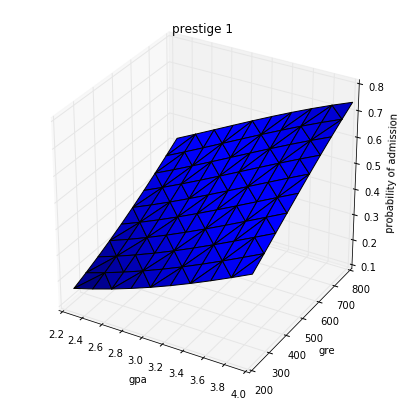

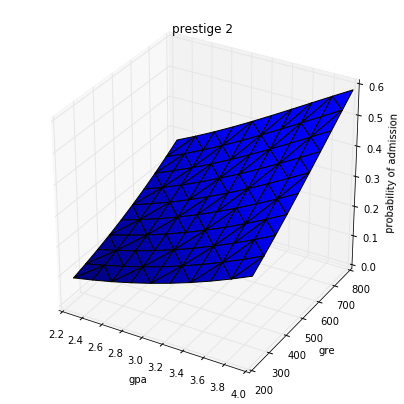

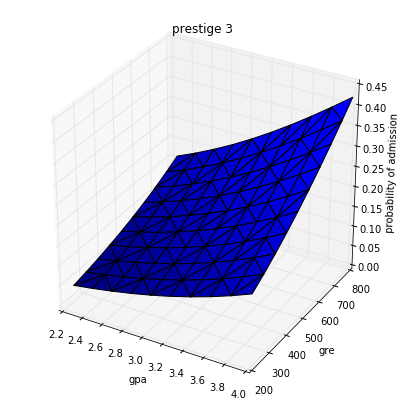

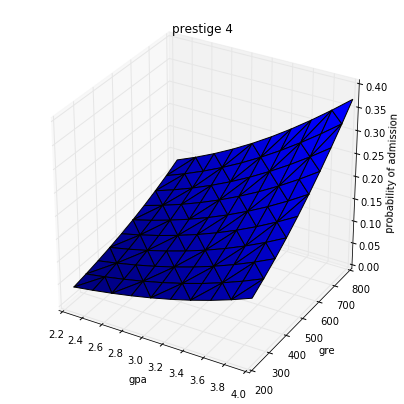

In [33]:
#create data frames for each prestige value
presCols = ['pres_2','pres_3','pres_4']

pres2 = pd.DataFrame(combos[['gre','gpa']], columns = ['gre','gpa'])
pres2['pres_2'] = 1.0
pres2['pres_3'] = 0.0
pres2['pres_4'] = 0.0
pres2['intercept'] = 1.0

pres3 = pres2.copy()
pres3.pres_2=0.0
pres3.pres_3 = 1.0

pres4 = pres2.copy()
pres4.pres_2=0.0
pres4.pres_4 = 1.0

pres1 = pres2.copy()
pres1.pres_2 = 0.0

#make predictions on each data frame
pres1['prob_admit'] = results.predict(pres1)
pres2['prob_admit'] = results.predict(pres2)
pres3['prob_admit'] = results.predict(pres3)
pres4['prob_admit'] = results.predict(pres4)

#create 3d plot of each data frame with probabilities as the z-axis

#prestige 1
fig1 = plt.figure(figsize=(7,7)).gca(projection='3d')
fig1.plot_trisurf(pres1.gpa,pres1.gre,pres1.prob_admit)
fig1.set_xlabel('gpa')
fig1.set_ylabel('gre')
fig1.set_zlabel('probability of admission')
fig1.set_title('prestige 1')


#prestige 2
fig2 = plt.figure(figsize=(7,7)).gca(projection='3d')
fig2.plot_trisurf(pres2.gpa,pres2.gre,pres2.prob_admit)
fig2.set_xlabel('gpa')
fig2.set_ylabel('gre')
fig2.set_zlabel('probability of admission')
fig2.set_title('prestige 2')

#presetige 3
fig3 = plt.figure(figsize=(7,7)).gca(projection='3d')
fig3.plot_trisurf(pres3.gpa,pres3.gre,pres3.prob_admit)
fig3.set_xlabel('gpa')
fig3.set_ylabel('gre')
fig3.set_zlabel('probability of admission')
fig3.set_title('prestige 3')

#presetige 4
fig4 = plt.figure(figsize=(7,7)).gca(projection='3d')
fig4.plot_trisurf(pres4.gpa,pres4.gre,pres4.prob_admit)
fig4.set_xlabel('gpa')
fig4.set_ylabel('gre')
fig4.set_zlabel('probability of admission')
fig4.set_title('prestige 4')

Visualizing these variables as surfaces, we can make intuitive sense of our predictions. 

For those who went to prestige 1 and prestige 2 schools, the surfaces are more or less planes. However, for prestige 3 and prestige 4 schools (the lower tier schools), you can see that as GRE and GPA increase, the odds of admission increase dramatically. 

This makes sense: if you went to a lower-tier school,the odds are not in your favor. However, if you show that you are a serious student, you can easily set yourself apart from the rest of your peers by earning high GPA and GRE scores. Though, this will only help so much. As you can see, the probabilities of admission for lower level schools still max out well below those for higher level schools.